In [1]:
# IANNwTF_Homework 07 - Autoencoders

import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline
import pandas as pd

# Helper Functions

In [2]:
def train_step(model, input, target, loss_function, optimizer):
    # if using dropout, add: training=True
    with tf.GradientTape() as tape:
        # for dropout, use: prediction = model(input, training)
        prediction = model(input)
        # print("prediction type: ",type(prediction))
        # print("target type: ",type(target))
        # print("input type: ",type(input))
        # print("prediction shape: ", prediction.shape)
        # print("target shape: ", target.shape)
        # print("input shape: ", input.shape)
        loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    test_losses = []
    test_accuracies = []

    #Modified for autoencoders (don't reuse)
    for input in test_data:
        # prediction = model(input, training)
        prediction = model(input)
        sample_test_loss = loss_function(input, prediction) + tf.reduce_sum(model.losses)

        # print('line 20: sample_test_loss is ', sample_test_loss)
        # axis=0 is the batch_size, axis=1 is the one-hot encoding of the labels
            
        sample_test_accuracy = np.argmax(input, axis=1) == np.argmax(prediction, axis=1)

        test_losses.append(sample_test_loss.numpy())
        # compute the sample_test_accuracy for each batch before appending
        test_accuracies.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_losses)
    test_accuracy = np.mean(test_accuracies)

    return test_loss, test_accuracy    

In [3]:
# visualize accuracy and loss for train_ds & test_ds
def plot(train_losses, test_losses, test_accuracies, figsize=(10,3)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].plot(train_losses, label='train')
    axes[0].plot(test_losses, label='test')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss', fontsize=20)
    axes[0].legend()
    axes[1].plot(test_accuracies)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    plt.ylim(0,1.0)
    axes[1].set_title('Accuracy' + str(round(np.max(test_accuracies))), fontsize=20)
    plt.show()

In [4]:
# implementation credits go to Group 16's Week04 homework
# option 1: gaussian standard distribution
def norm_std():
  return tf.image.per_image_standardization(image)

# option 2: normalize to (0,1)
def norm_0_1(x):
  max = 255
  min = 0
  result = tf.math.subtract(x, min)
  norm_image = tf.math.divide(result, (max - min))
  return norm_image

# option 3: normalize to (-1,1)
def norm_neg_1(x):
  result = norm_0_1(x)
  result = tf.math.multiply(result, 2)
  norm_image = tf.math.subtract(result, 1)
  return norm_image

#Encoder Component

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(28,28,1))
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None,input_shape=(28,28,1))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.Activation('relu')
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=None)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation('relu')
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=None)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.Activation('relu')

        self.conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation=None)
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()
        self.relu4 = tf.keras.layers.Activation('relu')
        self.output_layer = tf.keras.layers.Dense(32, activation=tf.keras.activations.softmax)

    def call(self, x):
        #print("input shape", x.shape)
        x = self.input_layer(x)
        #print("post input layer", x.shape)
        x = self.conv1(x)
        #print("post conv1 layer", x.shape)
        x = self.batch_norm_1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch_norm_2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batch_norm_3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        x = self.batch_norm_4(x)
        x = self.relu4(x)
        x = self.output_layer(x)
        return x

#Decoder Component

In [6]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense_restore = tf.keras.layers.Dense(128, activation=tf.keras.activations.softmax)
        self.conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=None, padding='same')
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.Activation('relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=None, padding='same')
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation('relu')
        self.upsample1 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.Activation('relu')
        self.upsample2 = tf.keras.layers.UpSampling2D(size=(2,2))

        
        
        #self.upsample3 = tf.keras.layers.UpSampling2D(size=(2,2))
        #apply convolution with one filter to get shape of (28,28,1)
        self.output_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid') #use sigmoid to reconstruct output as range of input is 0-1 using norm_0_1

    def call(self, x):
        #x = self.dense_restore(x)
        x = self.conv1(x)
        x = self.batch_norm_1(x)
        x = self.relu1(x)
        # print("after conv1: ", x.shape)
        x = self.conv2(x)
        x = self.batch_norm_2(x)
        x = self.relu2(x)
        # print("after conv2: ", x.shape)

        x = self.upsample1(x)
        # print("after upsample1: ", x.shape)
        x = self.conv3(x)
        x = self.batch_norm_3(x)
        x = self.relu3(x)
        # print("after conv3: ", x.shape)
        x = self.upsample2(x)
        # print("after upsample2: ", x.shape)

        x = self.output_layer(x)
        # print("after output_layer: ", x.shape)
        # print("returning x from decoder")
        return x

#Autoencoder

In [7]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#Load Dataset

(60000, 28, 28)
<class 'numpy.ndarray'>
(10000, 28, 28)
(28, 28)
(28, 28)
(28, 28)


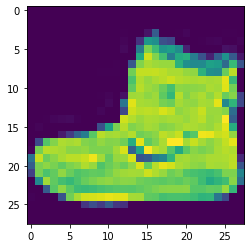

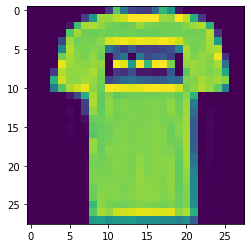

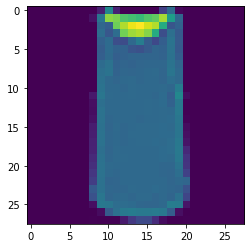

In [31]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, _), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(type(train_images))
print(test_images.shape)


count = 3

for each in train_images:
    plt.figure()
    plt.imshow(each)
    print(each.shape)
    count -= 1
    if count==0:
        break

#Preprocess Dataset

In [9]:
BATCH_SIZE = 32
#reshape datasets
print("train_images Before reshape: ", train_images.shape)
train_images = train_images.reshape(train_images.shape + (1,))
print("train_images After reshape:", train_images.shape)
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)

#Ensure image values are between 0 and 1
train_ds_images = train_ds_images.map(lambda image: norm_0_1(image))
train_ds_images = train_ds_images.shuffle(buffer_size=10000)

#Shuffling and batching
train_images_batched = train_ds_images.batch(BATCH_SIZE)
train_images_total = train_images_batched.prefetch(tf.data.experimental.AUTOTUNE)


#Repeat procedures for testing data
print("test_images Before reshape: ", test_images.shape)
test_images = test_images.reshape(test_images.shape + (1,))
print("test_images After reshape:", test_images.shape)
test_ds_images = tf.data.Dataset.from_tensor_slices(test_images)
test_ds_images = test_ds_images.map(lambda image: norm_0_1(image))
test_ds_images = test_ds_images.shuffle(buffer_size=10000)
test_images_batched = test_ds_images.batch(BATCH_SIZE)
test_images_total = test_images_batched.prefetch(tf.data.experimental.AUTOTUNE)

train_images Before reshape:  (60000, 28, 28)
train_images After reshape: (60000, 28, 28, 1)
test_images Before reshape:  (10000, 28, 28)
test_images After reshape: (10000, 28, 28, 1)


#Train Step

In [10]:
tf.keras.backend.clear_session()

num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate)

loss_function = tf.keras.losses.BinaryCrossentropy()
#loss_function = tf.keras.losses.MeanSquaredError()

model = Autoencoder()


# Initialize lists for later visualization
train_losses = []

test_losses = []
test_accuracies =[]

# print("Status: testing once on test data before start")
# test_loss, test_accuracy = test(model, test_images_total, loss_function)
# test_losses.append(test_loss)
# test_accuracies.append(test_accuracy)


# print("Status: Check how model performs on train data once before start")
# train_loss, _ = test(model, train_images_total, loss_function)
# train_losses.append(train_loss)

#Modified for autoencoders (don't reuse)
print("Status: Starting training")
for epoch in range(num_epochs):
    print('Epoch: ', str(epoch))

    # training
    running_average = 0
    for sample in train_images_total:
        #print(type(sample))
        #print(sample)
        train_loss = train_step(model, sample, sample, loss_function, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    print('running average is ', tf.get_static_value(running_average))
    train_losses.append(tf.get_static_value(running_average))
    print('Train loss in Epoch ', epoch, ' is ', tf.get_static_value(running_average))

    # testing
    test_loss, test_accuracy = test(model, test_images_total, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test loss in Epoch ', epoch, ' is ', test_loss)
    print('Test accuracy in Epoch ', epoch, ' is ', test_accuracy)

Status: Starting training
Epoch:  0
running average is  0.25966308
Train loss in Epoch  0  is  0.25966308
Test loss in Epoch  0  is  0.26321113
Test accuracy in Epoch  0  is  0.3416711832496577
Epoch:  1
running average is  0.2564265
Train loss in Epoch  1  is  0.2564265
Test loss in Epoch  1  is  0.25902078
Test accuracy in Epoch  1  is  0.35376611706983113
Epoch:  2
running average is  0.2511954
Train loss in Epoch  2  is  0.2511954
Test loss in Epoch  2  is  0.2578106
Test accuracy in Epoch  2  is  0.37943932565038796
Epoch:  3
running average is  0.2548349
Train loss in Epoch  3  is  0.2548349
Test loss in Epoch  3  is  0.25479883
Test accuracy in Epoch  3  is  0.3988225981287084
Epoch:  4
running average is  0.25257763
Train loss in Epoch  4  is  0.25257763
Test loss in Epoch  4  is  0.25322402
Test accuracy in Epoch  4  is  0.4218393427658603
Epoch:  5
running average is  0.25184548
Train loss in Epoch  5  is  0.25184548
Test loss in Epoch  5  is  0.25230002
Test accuracy in Epoc

#Training Visualization

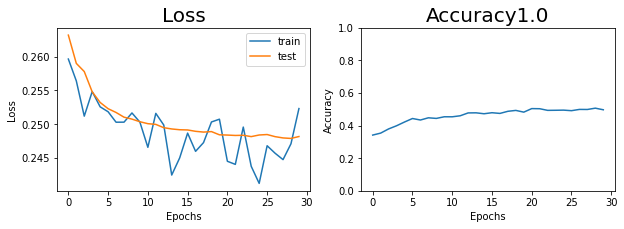

In [11]:
plot(train_losses, test_losses, test_accuracies)

In [12]:
# Save the weights
#model.save_weights('./checkpoints/my_checkpoint')
"""
PLEASE COMMENT THE ABOVE LINE OUT IN SUBSEQUENT EXECUTIONS OR OLD WEIGHTS WILL BE ERASED
"""

# # Create a new model instance
#model = Autoencoder()

# # Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# # Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

'\nPLEASE COMMENT THE ABOVE LINE OUT IN SUBSEQUENT EXECUTIONS OR OLD WEIGHTS WILL BE ERASED\n'

In [13]:
# Restore the weights
#model.load_weights('./checkpoints/my_checkpoint')

# test_loss, test_accuracy = test(model, test_images_total, loss_function)
# print('Test loss in Epoch ', epoch, ' is ', test_loss)
# print('Test accuracy in Epoch ', epoch, ' is ', test_accuracy)

**Label 	Description**<br/>
0--------T-shirt/top<br/>
1--------Trouser<br/>
2--------Pullover<br/>
3--------Dress<br/>
4--------Coat<br/>
5--------Sandal<br/>
6--------Shirt<br/>
7--------Sneaker<br/>
8--------Bag<br/>
9--------Ankle boot<br/>

In [23]:
def show_data(X, n=10, height=28, width=28, title=""):
    plt.figure(figsize=(10,3))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(X.reshape((height,width)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize=20)

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
Label of picture:  9
Label of picture:  2
Label of picture:  1
Label of picture:  1
Label of picture:  6


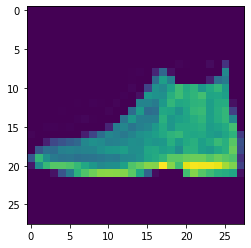

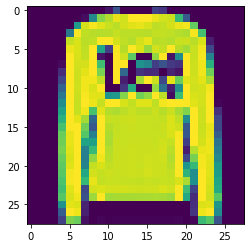

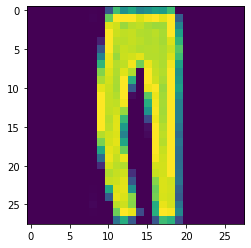

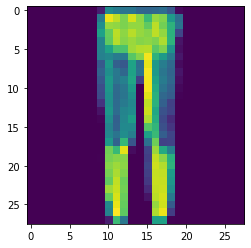

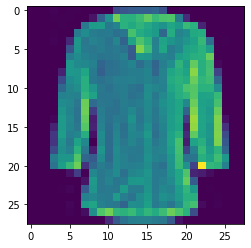

In [25]:
#Reloading Mnist dataset for fresh unshuffled images and labels
(_, _), (new_test_images, new_test_labels) = fashion_mnist.load_data()
sample_images = new_test_images[:1000]
sample_labels = new_test_labels[:1000]

counter = 5

for image in sample_images:
    plt.figure()
    plt.imshow(image)
    print(image.shape)
    counter -= 1
    if counter==0:
        break

counter = 5
for label in sample_labels:
    print("Label of picture: ", label)
    counter -= 1
    if counter==0:
        break

#make a dataset containing 1000 images for visualization
sample_images = sample_images.reshape(sample_images.shape + (1,))
sample_images_slice = tf.data.Dataset.from_tensor_slices(sample_images)
sample_images_slice = sample_images_slice.map(lambda image: norm_0_1(image))

#sample_images_slice = sample_images_slice.shuffle(buffer_size=10000)
sample_slice_batched = sample_images_slice.batch(1)
sample_images_total = sample_slice_batched.prefetch(tf.data.experimental.AUTOTUNE)

#print(sample_labels[label])
# sample_labels_slice = tf.data.Dataset.from_tensor_slices(sample_labels)
# sample_labels_slice = sample_labels_slice.map(lambda image: norm_0_1(image))
# sample_labels_slice = sample_labels_slice.shuffle(buffer_size=10000)
# sample_slice_batched = sample_labels_slice.batch(BATCH_SIZE)
# sample_labels_total = sample_labels_total.prefetch(tf.data.experimental.AUTOTUNE)

encoder_model = Encoder()
decoder_model = Decoder()

encoded_images = None

i = 0
for image in sample_images_total:
    encoded_image = encoder_model(image)

    if i==0:
        encoded_images = encoded_image
    else:
        encoded_images = tf.concat([encoded_images, encoded_image],0)
    i += 1
    # encoded_image_batch = encoded_image_batch.unbatch()
    # encoded_images.concat([encoded_images,encoded_image_batch],0)


In [35]:
print(encoded_images.shape)
print(type(encoded_images))
print(sample_images.shape)
print(type(sample_images))

(1000, 7, 7, 32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1000, 28, 28, 1)
<class 'numpy.ndarray'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


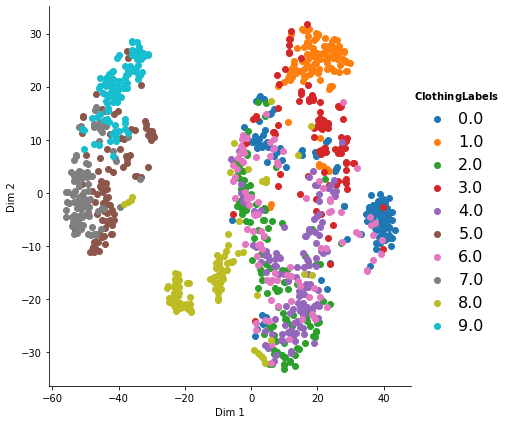

In [16]:
tsne = TSNE(n_components=2, random_state=0)
#nsamples, nx, ny, nz = sample_images.shape
#sample_images = sample_images.reshape((nsamples, nx*ny*nz))
#tsne_data = tsne.fit_transform(sample_images)

#Transforming encoder output into a form the tsne model can use
encoded_images_ndarr = encoded_images.numpy()
nsamples, nx, ny, nz = encoded_images_ndarr.shape
encoded_images_ndarr = encoded_images_ndarr.reshape((nsamples, nx*ny*nz))
tsne_data = tsne.fit_transform(encoded_images_ndarr)
tsne_data = np.vstack((tsne_data.T, sample_labels)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim 1", "Dim 2", "label"))

g = sns.FacetGrid(tsne_df, hue="label", size=6, legend_out=True).map(plt.scatter, "Dim 1", "Dim 2")
g.add_legend(title='$\\bf{Clothing Labels}$',handlelength=1,prop={'size': 16})
plt.show()

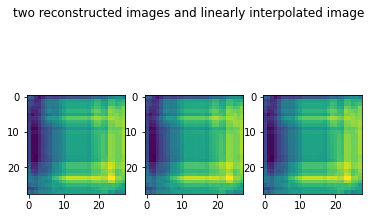

In [41]:
interpl_emb = tf.math.reduce_mean(tf.stack([encoded_images[0], encoded_images[1]]), axis=0)
interpl_emb = tf.expand_dims(interpl_emb, axis=0)
de = Decoder()
# decoded_images = de(encoded_images)
# decoded_images_arr = decoded_images.numpy()
# print(decoded_images_arr.shape)
# decoded_images_arr = decoded_images_arr.reshape((1000,28,28))
# # for i in range(1000):
# #     decoded_images_arr[i] = decoded_images_arr[i]*255

# counter = 5
# for image in decoded_images_arr:
#     plt.figure()
#     plt.imshow(image)
#     print(image.shape)
#     counter -= 1
#     if counter==0:
#         break
recon_1 = de(tf.expand_dims(encoded_images[0], axis=0))
recon_2 = de(tf.expand_dims(encoded_images[1], axis=0))
interpolated_image = de(interpl_emb)

fig, axs = plt.subplots(1,3)
fig.suptitle('two reconstructed images and linearly interpolated image')
axs[0].imshow(tf.squeeze(recon_1))
axs[1].imshow(tf.squeeze(recon_2))
axs[2].imshow(tf.squeeze(interpolated_image))